In [465]:
import requests, json, csv, re
import pandas as pd
import numpy as np


AKUurl = 'https://api.statbank.dk/v1/data/AKU125/CSV?lang=en&valuePresentation=Value&timeOrder=Descending&delimiter=Semicolon&allowVariablesInHead=true&S%C3%86SON=11&S%C3%86SON=10&BESKSTATUS=LPCT&TID=*'
AKUcsv = pd.read_csv(AKUurl, sep = ";")

unemp_url = 'https://api.statbank.dk/v1/data/AUS07/CSV?lang=en&valuePresentation=Value&timeOrder=Descending&delimiter=Semicolon&allowVariablesInHead=true&YD=TOT&YD=NET&TID=*&SAESONFAK=9&SAESONFAK=22'
raw_unemp = pd.read_csv(unemp_url, sep = ";")
AKUcsv.head(5)

,SÆSON,BESKSTATUS,TID,INDHOLD
0,Non-seasonally adjusted,ILO-unemployment rate,2018M06,5.0
1,Non-seasonally adjusted,ILO-unemployment rate,2018M05,4.9
2,Non-seasonally adjusted,ILO-unemployment rate,2018M04,5.1
3,Non-seasonally adjusted,ILO-unemployment rate,2018M03,5.1
4,Non-seasonally adjusted,ILO-unemployment rate,2018M02,5.2


In [466]:
AKUcsv['season_adj'] = np.where(AKUcsv['SÆSON'] == 'Non-seasonally adjusted', 0, 1)
AKUcsv.columns = ['todrop', 'type', 'time', 'rate', 'season_adj']
AKUcsv['type'] = AKUcsv['type'].str.replace(r'rate', r'')
AKU = AKUcsv.drop('todrop', axis=1)

raw_unemp['season_adj'] = np.where(raw_unemp['SAESONFAK'] == 'Seasonally adjusted figures in percent of the labour force', 1, 0)
raw_unemp.columns = ['type', 'time', 'SAESONFAK', 'rate', 'season_adj']
unemp = raw_unemp.drop('SAESONFAK', axis=1)

In [467]:
# merge data to long format.
# Now we have 6 unemp_rates per month. 3 types, all both w/ and w/o seasonal correction. 
all_long = pd.concat([AKU, unemp], ignore_index=True)

# shortening of type names
all_long['type'] = all_long['type'].str.replace(r'unemployment', r'unemp. ')
all_long.head(3)

,type,time,rate,season_adj
0,ILO-unemp.,2018M06,5.0,0
1,ILO-unemp.,2018M05,4.9,0
2,ILO-unemp.,2018M04,5.1,0


In [468]:
# Nice view for comparison, not workable going forward
all_wide_nice = all_long.pivot_table(index = 'time', columns= ['type','season_adj'], values= 'rate')
all_wide_nice.head(3)

type       Gross unemp.       ILO-unemp.        Net unemp.      
season_adj             0    1            0    1           0    1
time                                                            
2007M01              4.7  4.3          4.2  4.1         3.7  3.2
2007M02              4.6  4.1          4.3  3.9         3.6  3.2
2007M03              4.3  3.9          3.9  3.7         3.3  3.0

In [469]:
# creating timestamp 
# NB: Timestamping converts YYYYMM to YYYY-MM-01
import datetime
all_long['time'] = all_long['time'].str.replace(r'\D', r' ')

all_long['time'] = pd.to_datetime(all_long['time'], format = "%Y %m" )

print(all_long.tail(3))
all_long.dtypes

            type       time  rate  season_adj
825  Net unemp.  2007-02-01   3.6           0
826  Net unemp.  2007-01-01   3.2           1
827  Net unemp.  2007-01-01   3.7           0


type                  object
time          datetime64[ns]
rate                 float64
season_adj             int32
dtype: object

In [470]:
all_long['measure'] = all_long['season_adj'].map(str) + str(" ") + all_long['type'].map(str)
all_long = all_long.drop(['type', 'season_adj'], axis=1)
all_wide = all_long.pivot('time', 'measure', 'rate')
all_wide.head(3)


measure,0 Gross unemp.,0 ILO-unemp.,0 Net unemp.,1 Gross unemp.,1 ILO-unemp.,1 Net unemp.
time,,,,,,
2007-01-01,4.7,4.2,3.7,4.3,4.1,3.2
2007-02-01,4.6,4.3,3.6,4.1,3.9,3.2
2007-03-01,4.3,3.9,3.3,3.9,3.7,3.0


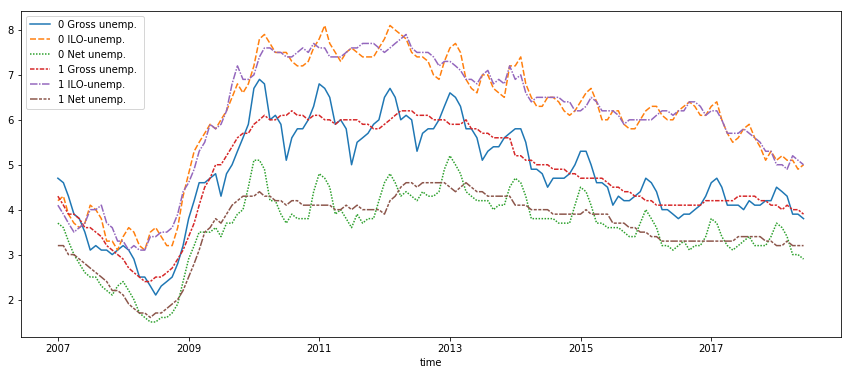

In [471]:
from matplotlib import pyplot
import seaborn as sns

fig, ax = pyplot.subplots(figsize = (14.7, 6))
sns.lineplot(ax=ax, data=all_wide)